In [1]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# data preprocessing

import pandas as pd
import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import string

# nltk.download('stopwords')


path = '../datasets/reviews.csv'

raw = pd.read_csv(path)
data = pd.read_csv(path)

# lowercase words 

raw['Text'] = raw['Text'].apply(str.lower)

# remove stopwords using NLTK
stop_words = set(stopwords.words('english')) 
raw['no_stopwords'] = raw['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# tokenize words using NLTK TweetTokenizer
tokenizer = TweetTokenizer()
raw['tokens'] = raw['no_stopwords'].apply(word_tokenize)

# lemmatization 
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

raw['lemmatized'] = raw['tokens'].apply(lemmatize_text)


# remove punctuation
punctuations = list(string.punctuation)

def remove_punctuation(list):
    new_list = []
    for word in list:
        if word not in punctuations:
            new_list.append(word)
    return new_list

raw['cleaned'] = raw['lemmatized'].apply(remove_punctuation)

#remove short length words
def remove_short_words(words):
    return [word for word in words if len(word) > 2]
raw['removed_short_word'] = raw['cleaned'].apply(remove_short_words)

#convert amazon.com to amazon
def convert_strings(words):
    converted_words = []
    for word in words:
        if word == 'amazon.com':
            converted_words.append('amazon')
        else:
            converted_words.append(word)

    return converted_words

raw['converted_strings'] = raw['removed_short_word'].apply(convert_strings)

#remove contractions
def remove_contractions(words):
    contractions = ["'re", "'ve", "'d", "'m", "'ll", "n't"]
    new_words = []

    for word in words:
        # Check if the word is a contraction
        if any([word.endswith(c) for c in contractions]):
            continue
        else:
            # If it isn't a contraction, append the word to the new list as is
            new_words.append(word)
    return new_words

raw['remove_contractions'] = raw['converted_strings'].apply(remove_contractions)

import re

def remove_urls(words):
    # Define the regular expression pattern for URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    new_words = []

    for word in words:
        # Check if the word is a URL
        if not url_pattern.match(word):
            # If it isn't a URL, append the word to the new list
            new_words.append(word)

    return new_words
raw['remove_urls'] = raw['remove_contractions'].apply(remove_urls)

def remove_digits(words):
    new_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            new_words.append(word)

    return new_words


raw['remove_digits'] = raw['remove_urls'].apply(remove_digits)

def remove_ellipses(words):
    new_words = []
    for word in words:
        if "…" not in word:
            new_words.append(word)
    return new_words


raw['remove_ellipses'] = raw['remove_digits'].apply(remove_ellipses)

data['cleaned'] = raw['remove_ellipses']

data['cleaned2'] = data['cleaned'].apply(' '.join)

In [7]:
data

,Sentiment,Time,Text,cleaned,cleaned2
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,"[healthy, dog, food, good, digestion, also, go...",healthy dog food good digestion also good smal...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,"[pleased, natural, balance, dog, food, dog, is...",pleased natural balance dog food dog issue dog...
2,positive,18/6/21,"Before I was educated about feline nutrition, ...","[educated, feline, nutrition, allowed, cat, be...",educated feline nutrition allowed cat become a...
3,positive,7/7/21,"My holistic vet recommended this, along with a...","[holistic, vet, recommended, this, along, bran...",holistic vet recommended this along brand trie...
4,positive,1/7/21,I bought this coffee because its much cheaper ...,"[bought, coffee, much, cheaper, ganocafe, orga...",bought coffee much cheaper ganocafe organic re...
...,...,...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med...","[okay, gift, box, like, mediocre, cheese, summ...",okay gift box like mediocre cheese summer saus...
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...,"[look, llike, walked, raw, deal, item, intoler...",look llike walked raw deal item intolerably st...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...,"[thank, god, tasted, metal, swallowed, them, d...",thank god tasted metal swallowed them dont eve...
5442,negative,13/9/20,This product was very good when I began buying...,"[product, good, began, buying, lately, terribl...",product good began buying lately terrible tast...


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned'])
sequences = tokenizer.texts_to_sequences(data['cleaned'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Label encoding
labels = np.array(data['Sentiment'].replace({'positive': 1, 'negative': 0}))

# train test split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels)

# Build RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
35/35 [==============================] - 4s 52ms/step - loss: 0.6125 - accuracy: 0.7139 - val_loss: 0.5738 - val_accuracy: 0.7401
Epoch 2/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5688 - accuracy: 0.7403 - val_loss: 0.5723 - val_accuracy: 0.7401
Epoch 3/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5668 - accuracy: 0.7403 - val_loss: 0.5720 - val_accuracy: 0.7401
Epoch 4/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5648 - accuracy: 0.7417 - val_loss: 0.5722 - val_accuracy: 0.7401
Epoch 5/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5609 - accuracy: 0.7527 - val_loss: 0.5666 - val_accuracy: 0.7401
Epoch 6/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5110 - accuracy: 0.7506 - val_loss: 0.4724 - val_accuracy: 0.8044
Epoch 7/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5577 - accuracy: 0.7656 - val_loss: 0.5759 - val_accuracy: 0.7410
Epoch 8/10
35

35/35 [==============================] - 1s 8ms/step


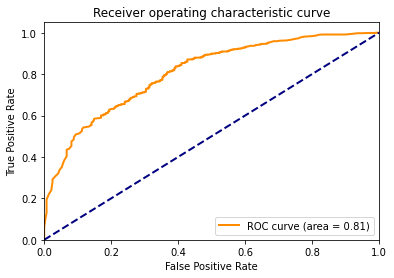

Precision: 0.85
Recall: 0.87
F1 score: 0.86


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Get predictions
y_pred = model.predict(x_test)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Compute precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred.round(), average='binary')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Print precision, recall, and F1 score
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1_score))

In [ ]:
y_pred = model.predict(x_test)
y_pred

35/35 [==============================] - 0s 7ms/step


array([[0.16438778],
       [0.84660465],
       [0.8466044 ],
       ...,
       [0.16438714],
       [0.8466046 ],
       [0.84660506]], dtype=float32)

## Different parameters

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, classification_report
from sklearn.model_selection import train_test_split

2023-04-03 17:43:32.974605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# from ast import literal_eval
# data = pd.read_csv("preprocessed.csv", index_col=0, converters={'cleaned':literal_eval})
data['cleaned2'] = data['cleaned'].apply(lambda x: ' '.join(x))
data

,Sentiment,Time,Text,cleaned,cleaned2
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,"[healthy, dog, food, good, digestion, also, go...",healthy dog food good digestion also good smal...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,"[pleased, natural, balance, dog, food, dog, is...",pleased natural balance dog food dog issue dog...
2,positive,18/6/21,"Before I was educated about feline nutrition, ...","[educated, feline, nutrition, allowed, cat, be...",educated feline nutrition allowed cat become a...
3,positive,7/7/21,"My holistic vet recommended this, along with a...","[holistic, vet, recommended, this, along, bran...",holistic vet recommended this along brand trie...
4,positive,1/7/21,I bought this coffee because its much cheaper ...,"[bought, coffee, much, cheaper, ganocafe, orga...",bought coffee much cheaper ganocafe organic re...
...,...,...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med...","[okay, gift, box, like, mediocre, cheese, summ...",okay gift box like mediocre cheese summer saus...
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...,"[look, llike, walked, raw, deal, item, intoler...",look llike walked raw deal item intolerably st...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...,"[thank, god, tasted, metal, swallowed, them, d...",thank god tasted metal swallowed them dont eve...
5442,negative,13/9/20,This product was very good when I began buying...,"[product, good, began, buying, lately, terribl...",product good began buying lately terrible tast...


In [10]:
from sklearn.preprocessing import LabelEncoder
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['cleaned2'])
sequences = tokenizer.texts_to_sequences(data['cleaned2'])
padded_sequences = pad_sequences(sequences)
data


,Sentiment,Time,Text,cleaned,cleaned2
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,"[healthy, dog, food, good, digestion, also, go...",healthy dog food good digestion also good smal...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,"[pleased, natural, balance, dog, food, dog, is...",pleased natural balance dog food dog issue dog...
2,positive,18/6/21,"Before I was educated about feline nutrition, ...","[educated, feline, nutrition, allowed, cat, be...",educated feline nutrition allowed cat become a...
3,positive,7/7/21,"My holistic vet recommended this, along with a...","[holistic, vet, recommended, this, along, bran...",holistic vet recommended this along brand trie...
4,positive,1/7/21,I bought this coffee because its much cheaper ...,"[bought, coffee, much, cheaper, ganocafe, orga...",bought coffee much cheaper ganocafe organic re...
...,...,...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med...","[okay, gift, box, like, mediocre, cheese, summ...",okay gift box like mediocre cheese summer saus...
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...,"[look, llike, walked, raw, deal, item, intoler...",look llike walked raw deal item intolerably st...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...,"[thank, god, tasted, metal, swallowed, them, d...",thank god tasted metal swallowed them dont eve...
5442,negative,13/9/20,This product was very good when I began buying...,"[product, good, began, buying, lately, terribl...",product good began buying lately terrible tast...


In [29]:
padded_sequences

array([[   0,    0,    0, ...,  138,  123,  724],
       [   0,    0,    0, ...,  647, 1061,   53],
       [   0,    0,    0, ...,   61,   14, 1038],
       ...,
       [   0,    0,    0, ...,   76,  209,  353],
       [   0,    0,    0, ...,   96,  523,  165],
       [   0,    0,    0, ...,   66,  208, 1067]], dtype=int32)

In [11]:
# Label encoding
le = LabelEncoder()
data["label"] = le.fit_transform(data["Sentiment"])

# train test split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state = 42)

# Build LSTM-RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

2023-04-03 17:47:38.859734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
35/35 [==============================] - 10s 233ms/step - loss: 0.5918 - accuracy: 0.7323 - val_loss: 0.5325 - val_accuracy: 0.7401
Epoch 2/10
35/35 [==============================] - 8s 215ms/step - loss: 0.4391 - accuracy: 0.7688 - val_loss: 0.3646 - val_accuracy: 0.8356
Epoch 3/10
35/35 [==============================] - 8s 217ms/step - loss: 0.2704 - accuracy: 0.9049 - val_loss: 0.3165 - val_accuracy: 0.8623
Epoch 4/10
35/35 [==============================] - 8s 226ms/step - loss: 0.1994 - accuracy: 0.9362 - val_loss: 0.2958 - val_accuracy: 0.8724
Epoch 5/10
35/35 [==============================] - 8s 222ms/step - loss: 0.1509 - accuracy: 0.9557 - val_loss: 0.2984 - val_accuracy: 0.8687
Epoch 6/10
35/35 [==============================] - 9s 259ms/step - loss: 0.1689 - accuracy: 0.9414 - val_loss: 0.2979 - val_accuracy: 0.8678
Epoch 7/10
35/35 [==============================] - 9s 258ms/step - loss: 0.1114 - accuracy: 0.9646 - val_loss: 0.3274 - val_accuracy: 0.8604
Epoch

In [12]:
model.evaluate(x_test,y_test)

35/35 [==============================] - 1s 29ms/step - loss: 0.3621 - accuracy: 0.8751


[0.3621266484260559, 0.8751147985458374]

In [13]:
y_pred = model.predict(x_test)

35/35 [==============================] - 1s 28ms/step


In [18]:
df_out = pd.DataFrame(y_test)
df_out

,label
1186,1
4765,0
410,1
1945,0
3848,1
...,...
1315,1
1041,1
2231,1
2464,1


In [30]:
df_out['predicted'] = y_pred.round()
df_out

,label,predicted
1186,1,1.0
4765,0,1.0
410,1,1.0
1945,0,1.0
3848,1,1.0
...,...,...
1315,1,1.0
1041,1,1.0
2231,1,0.0
2464,1,1.0


In [31]:
predicted_df = data.merge(df_out, left_index=True, right_index=True)
predicted_df

,Sentiment,Time,Text,cleaned,cleaned2,label_x,label_y,predicted
8,positive,19/7/21,I ordered this product two times now and have ...,"[ordered, product, two, time, happy, delivery,...",ordered product two time happy delivery produc...,1,1,1.0
12,positive,21/7/21,I've been feeding liver biscotti for years. I ...,"[feeding, liver, biscotti, year, looking, heal...",feeding liver biscotti year looking healthy tr...,1,1,1.0
15,positive,30/6/21,I tried this chips in a hotel that I stayed at...,"[tried, chip, hotel, stayed, loved, them, orde...",tried chip hotel stayed loved them ordered off...,1,1,1.0
17,positive,24/8/21,I picked up a few bags of these at my local HE...,"[picked, bag, local, heb, couldnt, help, consu...",picked bag local heb couldnt help consume half...,1,1,0.0
23,positive,15/7/21,I am a mom of 3 kids. With my older two I had ...,"[mom, kid, older, two, hard, time, finding, sn...",mom kid older two hard time finding snack much...,1,1,1.0
...,...,...,...,...,...,...,...,...
5421,negative,17/4/21,I have been feeding these to our dog for years...,"[feeding, dog, year, help, joint, especially, ...",feeding dog year help joint especially hip eve...,0,0,0.0
5428,negative,21/4/21,I have been giving these chews to my Mini-Pinc...,"[giving, chew, mini-pincher, mini-dauchand, pa...",giving chew mini-pincher mini-dauchand past ye...,0,0,0.0
5437,negative,16/11/20,I bought this at a local Albertsons recently a...,"[bought, local, albertsons, recently, advertis...",bought local albertsons recently advertised ch...,0,0,0.0
5438,negative,27/2/20,Reese changed their Cheesy Popcorn Seasoning. ...,"[reese, changed, cheesy, popcorn, seasoning, s...",reese changed cheesy popcorn seasoning salt ch...,0,0,0.0


In [32]:
predicted_df.to_csv('../datasets/predicted_sentiment.csv')

In [33]:
accuracy = accuracy_score(y_test, y_pred.round())
precision = precision_score(y_test, y_pred.round())
auc = roc_auc_score(y_test, y_pred.round())

print("Accuracy = ",accuracy)
print("Precision = ", precision)
print("ROC AUC = ", auc)
print(classification_report(y_test, y_pred.round()))

Accuracy =  0.8622589531680441
Precision =  0.8904761904761904
ROC AUC =  0.801475681505318
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       283
           1       0.89      0.93      0.91       806

    accuracy                           0.86      1089
   macro avg       0.83      0.80      0.81      1089
weighted avg       0.86      0.86      0.86      1089



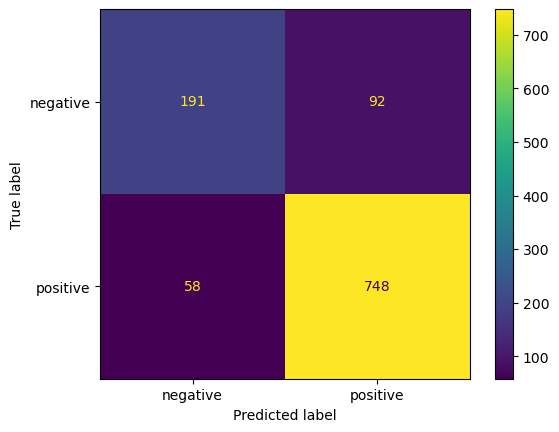

In [34]:
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred.round())

cm = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ["negative", "positive"])
cm.plot()